In [1]:
import numpy as np
from scipy import special
import pandas as pd
from scipy.stats import truncnorm, bernoulli
from sklearn.model_selection import train_test_split
import random
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import tqdm
from plotnine import *
from scipy.stats import spearmanr
import plotnine as gg
from numpy import savez_compressed


## Task definition

In [ ]:
def PRLtask_2ParamRL_attentionstate(
    parameters,
    to_attentive_tau,
    to_inattentive_tau,
    numtrials,
    pval,
    minswitch,
    numaction,
    agentid,
):
    """
    #### Inputs ####
      parameters : model parameter values (list)
      numtrials : number of trials we want to simulate for an agent (int)
      pval : probability of the correct action being rewarded (float)
      minswitch : minimum number of trials required for the correct actions to reverse (int)
      numaction : total number of possible actions (int)
      agentid : the sequential ID label for the agent that is being simulated (int)


    #### Outputs ####

      data : a pandas data frame containing true parameter values, agent actions/rewards, agent id, trials etc.
    """

    softmaxbeta = parameters[0] * 10  # softmax beta
    learningrate = parameters[1]  # learning rate

    actionQvalues = np.array(
        [1 / numaction, 1 / numaction]
    )  # initialize action values (1/number of actions)
    CurrentlyCorrect = random.choice(
        [0, 1]
    )  # initialize the action that is more likely to be rewarded at first
    currLength = minswitch + random.randint(
        0, 5
    )  # the number of correct trials required for the correct action to switch
    currCum = 0  # initialize cumulative reward

    allactions = []  # initialize list that will store all actions
    allrewards = []  # initialize list that will store all rewards
    allcorrectchoices = []  # initialize list that will store all correct actions
    isswitch = [
        0
    ] * numtrials  # initialize the list that will store an index of switch trials (1 if switch, 0 otherwise)
    alltrials = []  # initialize the list that will store the list of trials
    alliscorrectaction = (
        []
    )  # initialize the list that will store whether the agent selected the currently correct action or not (different from the reward)
    qvalA1 = []
    qvalA2 = []
    all_whichstate = []
    whichState = 1  # initialize at attention state

    T = parameters[2]
    tau = to_inattentive_tau  # 1-(1/T)
    tau2 = to_attentive_tau

    for i in range(numtrials):
        if whichState == 0:
            if np.random.uniform(0, 1, 1)[0] > tau2:
                whichState = 1 - whichState

        else:
            if np.random.uniform(0, 1, 1)[0] > tau:
                whichState = 1 - whichState

        if whichState == 1:  # if in attention state
            sftmx_p = special.softmax(
                softmaxbeta * actionQvalues
            )  # generate the action ps using the softmax
            action = np.random.choice(
                numaction, p=sftmx_p
            )  # generate the action using the probability

        else:  # if in random state
            action = random.choice([0, 1])  # choose randomly between the two actions

        correct = (
            action == CurrentlyCorrect
        )  # is the selected action the action that is currently rewarding
        correct = int(correct)
        genrandomvalue = np.random.uniform(0, 1, 1)[0]

        if genrandomvalue < pval:  # if correct, reward with p probability
            r = correct
        else:
            r = 1 - correct

        RPE = r - actionQvalues[action]

        if whichState == 1:  # update if < smaller than tau
            actionQvalues[action] += learningrate * RPE
            unchosenaction = 1 - action
            RPEunchosen = (1 - r) - actionQvalues[unchosenaction]
            actionQvalues[unchosenaction] += learningrate * RPEunchosen

        currCum = currCum + r  # update cumulative reward
        if (r == 1) and (
            currCum >= currLength
        ):  # check for the counter of the trials required to switch correct actions
            CurrentlyCorrect = 1 - CurrentlyCorrect
            currLength = minswitch + random.randint(0, 5)
            currCum = 0
            if i < numtrials - 1:
                isswitch[i + 1] = 1
        # store all trial variables
        allactions.append(action)
        allrewards.append(r)
        allcorrectchoices.append(CurrentlyCorrect)
        alltrials.append(i)
        alliscorrectaction.append(correct)
        qvalA1.append(actionQvalues[0])
        qvalA2.append(actionQvalues[1])
        all_whichstate.append(whichState)
    data = pd.DataFrame(
        {
            "agentid": [agentid] * len(allactions),
            "actions": allactions,
            "correct_actions": allcorrectchoices,
            "rewards": allrewards,
            "isswitch": isswitch,
            "iscorrectaction": alliscorrectaction,
            "trials": alltrials,
            "alpha": [learningrate] * len(allactions),
            "beta": [softmaxbeta] * len(allrewards),
            "Q_a1": qvalA1,
            "Q_a2": qvalA2,
            "to_inattentive_tau": [tau] * len(allactions),
            "to_attentive_tau": [tau2] * len(allactions),
            "which_state": all_whichstate,
        }
    )

    return data


tau = 0.94
beta = 0.5
alpha = 0.5
parameters = [beta, alpha, tau]
numtrials = 2000
pval = 0.6
minswitch = 10
numaction = 2
agentid = 2
data = PRLtask_2ParamRL_attentionstate(
    parameters, tau, tau, numtrials, pval, minswitch, numaction, agentid
)  # test out the function...

## Simulation

In [ ]:
N_AGENTS = 3000
suffix = '_val'

#tau_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
to_inattentive_tau_range = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
to_attentive_tau_range = [0.7]

pval=0.8
numtrials = 2000
minswitch = 10
numaction = 2

train_data_list = []
result = {'to_inattentive_tau': [], 'to_attentive_tau': [], 'attention_state_avg': []}
aid = 1
for t1 in to_attentive_tau_range:
  for t2 in to_inattentive_tau_range:
    data_list = []
    for _ in tqdm.tqdm(range(int(N_AGENTS/len(to_inattentive_tau_range)))):
      rand_beta = random.uniform(0.2, 0.6)
      rand_alpha = random.uniform(0.5, 1)
      parameters = [rand_beta, rand_alpha, 0]
      data=PRLtask_2ParamRL_attentionstate(parameters, t1, t2, numtrials,pval,minswitch,numaction, aid)
      data_list.append(data['which_state'].mean())
      train_data_list.append(data)
      aid += 1

    result['to_attentive_tau'].append(t1)
    result['to_inattentive_tau'].append(t2)
    result['attention_state_avg'].append(np.mean(data_list))

train_df = pd.concat(train_data_list)

[Text(0.5, 0, 'agent no'),
 Text(0, 0.5, 'attentive states percent'),
 Text(0.5, 1.0, 'Attentive States Percentage in 2000 trials')]

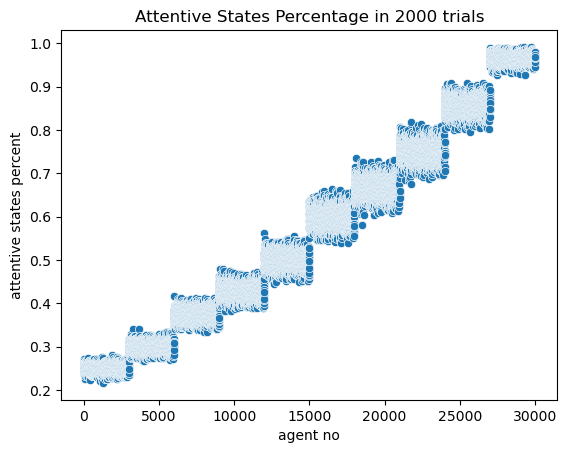

In [2]:
import seaborn as sns

train_df = pd.read_csv('data/vara_30000agent_2000t_2ParamRL_intractable.csv')
N_AGENTS = len(train_df['agentid'].unique())
numtrials = len(train_df['trials'].unique())
prefix = f'vara_{N_AGENTS}agent_{numtrials}t_2ParamRL_intractable'
labels = train_df['which_state'].to_numpy().astype(np.float32).reshape((N_AGENTS, numtrials))

ax = sns.scatterplot(np.mean(labels, axis=1))
ax.set(xlabel="agent no", ylabel="attentive states percent", title='Attentive States Percentage in 2000 trials')

In [13]:
from prl_utils import (
    Mode,
    get_features,
    get_labels,
)

suffix = '_val'
features = get_features(train_df, N_AGENTS, numtrials, mode=Mode.PRL2_intractable_high_tau)
savez_compressed(f'data/{prefix}_features{suffix}.npz', features)
savez_compressed(f'data/{prefix}_labels{suffix}.npz', labels)

pest_labels = get_labels(train_df, Mode.PRL2_intractable_high_tau)
savez_compressed(f'data/{prefix}_pest_labels{suffix}.npz', pest_labels)

In [ ]:
train_df.to_csv(f"data/{prefix}{suffix}.csv")

In [ ]:
df_X = pd.DataFrame(result)
df_X = df_X.pivot("to_inattentive_tau", "to_attentive_tau", "attention_state_avg")
df_X.sort_index(level=0, ascending=False, inplace=True)
ax = sns.heatmap(df_X, annot=True)
ax.set(xlabel="to attentive threshold", ylabel="to inattentive threshold", title='Attentive States Percentage in 2000 trials')

#plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/latent/attentive_states_w_different_taus.png")

## Analyze simulation

In [ ]:
def analyzeSwitch(subdata,numPreSwitchTrials,numPostSwitchTrials):
  switches= [k for k, x in enumerate(subdata['isswitch']) if x]

  corr =  np.array(subdata['iscorrectaction']) #np.equal(np.array(subdata['correct_actions']),np.array(subdata['actions']))
  corr=corr.astype(int)

  switches=[x for x in switches if x <= subdata.shape[0]-numPostSwitchTrials]
  allswitchaccuracy=np.nan*np.ones([len(switches),numPreSwitchTrials+numPostSwitchTrials])

  for s in range(len(switches)):
    sw = switches[s]
    allswitchaccuracy[s]= np.array(corr[np.arange(sw-numPreSwitchTrials,sw+numPostSwitchTrials)])#np.array(corr[np.arange[sw-numPreSwitchTrials:sw+numPostSwitchTrials]])

  LC=np.nanmean(allswitchaccuracy,0)

  return LC

In [ ]:
def threebackanalysis(subdata):
  reward = np.array(subdata.rewards)
  p3 = np.array([0]*len(reward)).astype(float)
  outcomes = [0,1]
  actions = np.array(subdata.actions)
  k = 0
  r1=reward[:len(reward)-3]
  r2=reward[1:len(reward)-2]
  r3=reward[2:len(reward)-1]

  firstnanvals = np.array([np.nan,np.nan,np.nan])

  for t1 in outcomes:
    for t2 in outcomes:
      for t3 in outcomes:
        k +=1
        r1_1 = r1 == t3
        r2_1 = r2 == t2
        r3_1 = r3 == t1
        allcorr = r1_1 & r2_1 & r3_1
        allcorr1 = np.concatenate([firstnanvals,allcorr])

        p3 += (k*allcorr1)
  # print(p3)
  isStay = actions[:len(actions)-1]==actions[1:len(actions)].astype(float)
  isStay = np.insert(isStay,0,np.nan)
  stay_3p =[]
  for i in range(1,9):
    stay_3p.append(np.nanmean(isStay[p3==i]))

  return stay_3p


In [ ]:
def abanalysis(subdata):
  actions =np.array(subdata.actions)
  reward = np.array(subdata.rewards)
  endidx = len(actions)

  isstay = actions[1:endidx]==actions[:endidx-1].astype(float)
  isstay =np.insert(isstay,0,np.nan)
  r1 = reward[0:endidx-2]
  r2 = reward[1:endidx-1]
  stay = isstay[1:endidx-1]



  p2 = np.array([0]*len(reward)).astype(float)
  k =0
  outcomes = [0,1]
  firstnanvals = np.array([np.nan,np.nan])
  for t2 in outcomes:
    for t1 in outcomes:
      for s1 in [1,0]:
        k += 1
        r1_1 = r1 == t2
        r2_1 = r2 == t1
        stay_2 = stay == s1
        allcorr = r1_1 & r2_1 & stay_2
        allcorr1 = np.concatenate([firstnanvals,allcorr])
        p2 += (k*allcorr1)
  stay2 = actions[:endidx-2]==actions[2:endidx].astype(float)
  stay2 = np.concatenate([firstnanvals,stay2])
  stayp2 =[]
  for i in range(1,9):
    stayp2.append(np.nanmean(stay2[p2==i]))

  return stayp2



In [ ]:
# train_df = pd.read_csv("/content/gdrive/My Drive/dl4rl/PRL/behall.csv")
numPreSwitchTrials =5 # number of trials before the switch
numPostSwitchTrials = 10 # number of trials after the switch


allsims=train_df['agentid'].unique()

numsimsplot=100
LCall = np.nan*np.ones([numsimsplot,numPreSwitchTrials+numPostSwitchTrials])
LC3backall = np.nan*np.ones([numsimsplot,8])
abanalysis_results = np.nan*np.ones([numsimsplot,8])

avgLCs =[]

for i in range(numsimsplot):
  minidataa = train_df.loc[train_df['agentid']==allsims[i],:]
  LCall[i]=analyzeSwitch(minidataa,numPreSwitchTrials,numPostSwitchTrials)
  LC3backall[i]=threebackanalysis(minidataa)
  abanalysis_results[i]=abanalysis(minidataa)
  avgLCs.append([minidataa.beta[0],minidataa.alpha[0],minidataa['T'][0],
                 np.mean(LCall[i][5:]),
                 np.mean(LC3backall[i][:4])])





prepostswitchaverage = np.nanmean(LCall,axis =0) # average across the entire sample.
prepostswitchaverageSEM =np.nanstd(LCall,axis=0)/np.sqrt(len(allsims))
trialsSinceSwitch = np.arange(-numPreSwitchTrials,numPostSwitchTrials) #for x axis, trials before and after the switch


from matplotlib.pyplot import figure

figure(figsize=(6, 7), dpi=80)

for a in LCall:
    # x_new = np.linspace(1,len(trialsSinceSwitch),50)
    # a_BSpline = interpolate.make_interp_spline(np.arange(len(trialsSinceSwitch))+1, a)
    # y_new = a_BSpline(x_new)
    plt.plot(trialsSinceSwitch,a,color='grey')

plt.plot(trialsSinceSwitch,prepostswitchaverage)
plt.errorbar(trialsSinceSwitch,prepostswitchaverage,prepostswitchaverageSEM,color='k')
plt.xlabel('trials since switch')
plt.xticks(trialsSinceSwitch)
plt.ylabel('p(Corr)')
plt.title('Aligned learning curve')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.ylim([0,1])
plt.hlines(0.5, -numPreSwitchTrials, numPostSwitchTrials, colors='r', linestyles='dashed', label='chance')
plt.hlines(0.8, -numPreSwitchTrials, numPostSwitchTrials, colors='k', linestyles='dashed', label='p(reward)')

leg = plt.legend(loc='upper right')

# plt.savefig("/content/gdrive/MyDrive/dl4rl/PRL/PRLsim2PRL.svg")

plt.show()


In [ ]:
abanalysis_results1=np.array([abanalysis_results[:,0],abanalysis_results[:,1],abanalysis_results[:,4],
abanalysis_results[:,5],abanalysis_results[:,2],abanalysis_results[:,3],
abanalysis_results[:,6]])


figure(figsize=(6, 7), dpi=80)


for a in range(abanalysis_results1.shape[1]):
    # x_new = np.linspace(1,len(trialsSinceSwitch),50)
    # a_BSpline = interpolate.make_interp_spline(np.arange(len(trialsSinceSwitch))+1, a)
    # y_new = a_BSpline(x_new)
    plt.plot(np.arange(1,8),abanalysis_results1[:,a],color='grey')


plt.plot(np.arange(1,8),np.nanmean(abanalysis_results1,axis=1),color ='k')





In [ ]:

figure(figsize=(6, 7), dpi=80)


for a in LC3backall:
    # x_new = np.linspace(1,len(trialsSinceSwitch),50)
    # a_BSpline = interpolate.make_interp_spline(np.arange(len(trialsSinceSwitch))+1, a)
    # y_new = a_BSpline(x_new)
    plt.plot(np.arange(1,9),a,color='grey')



plt.plot(np.arange(1,9),np.nanmean(LC3backall,axis=0),color ='k')


In [ ]:
df = pd.DataFrame(avgLCs)
df.columns = ['beta','alpha','T','sumstatsLC','sumstatsLC3back']

xx = 'beta'
yy = 'sumstatsLC3back'


r_value, p_value = spearmanr(df[xx], df[yy])

plott = gg.ggplot(df, gg.aes(x = xx, y = yy)) + gg.geom_point(color = 'blue') + gg.stat_smooth(method = 'lm') + gg.xlab('True ' + xx) + gg.ylab('DL ' + yy ) +gg.labels.ggtitle('r='+str(np.round(r_value,2))+',p='+str(np.round(p_value,2)))


plott